In [50]:
#Goal of this notebook: Making a model that can predict the virality of a TikTok video based on its 
# early engagement metrics and metadata.

import pandas as pd
import numpy as np

In [84]:
#reading the training data

df = pd.read_csv("train.csv")
df.head()

,url,digg_count,play_count,share_count,repost_count,collect_count,comment_count,video_id,author_id,duration,description,create_time,author_unique_id,location_created
0,https://www.tiktok.com/@zachking/video/1001169...,857800.0,1700000.0,476.0,0.0,335.0,1508.0,100116967235219456,6.861650e+16,0.0,When it's trash night at my house #dailylife,1464212460,zachking,NaN
1,https://www.tiktok.com/@zachking/video/1164457...,1100000.0,2000000.0,637.0,0.0,467.0,1988.0,116445712837398528,6.861650e+16,15.0,#MamaSaid to always be a gentleman,1468105536,zachking,NaN
2,https://www.tiktok.com/@zachking/video/1165721...,1000000.0,2100000.0,790.0,0.0,455.0,2683.0,116572195421646848,6.861650e+16,11.0,I've got #NoMoney ...oh wait,1468135692,zachking,NaN
3,https://www.tiktok.com/@zachking/video/1185885...,1200000.0,2600000.0,3157.0,0.0,1616.0,7378.0,118588521136766976,6.861650e+16,13.0,#PikachuBeatDrop I found a pikachu,1468616422,zachking,NaN
4,https://www.tiktok.com/@zachking/video/1214467...,806700.0,2300000.0,831.0,0.0,513.0,2287.0,121446730818019328,6.861650e+16,15.0,My heart will go on forever #badflutesong,1469297872,zachking,NaN


In [85]:
#train_data information

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2060 entries, 0 to 2059
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   url               2060 non-null   object 
 1   digg_count        2057 non-null   float64
 2   play_count        2057 non-null   float64
 3   share_count       2057 non-null   float64
 4   repost_count      2057 non-null   float64
 5   collect_count     2057 non-null   float64
 6   comment_count     2057 non-null   float64
 7   video_id          2060 non-null   int64  
 8   author_id         2057 non-null   float64
 9   duration          2057 non-null   float64
 10  description       1970 non-null   object 
 11  create_time       2060 non-null   int64  
 12  author_unique_id  2057 non-null   object 
 13  location_created  1999 non-null   object 
dtypes: float64(8), int64(2), object(4)
memory usage: 225.4+ KB


In [86]:
#from here we can see that 'url, video_id, author_id, author_unique_id, location_created' is not needed for calculation
#also 'description' field is very important, however for the scope of this feature we won't be doing NLP, so we ignore it

In [87]:
df_clean = df[[
    "digg_count",
    "share_count",
    "repost_count",
    "collect_count",
    "comment_count",
    "duration",
    "create_time",
    "play_count"
]].copy()

In [88]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2060 entries, 0 to 2059
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   digg_count     2057 non-null   float64
 1   share_count    2057 non-null   float64
 2   repost_count   2057 non-null   float64
 3   collect_count  2057 non-null   float64
 4   comment_count  2057 non-null   float64
 5   duration       2057 non-null   float64
 6   create_time    2060 non-null   int64  
 7   play_count     2057 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 128.9 KB


In [89]:
#there are only few rows which have missing/null data, we will just remove them because it won't create a significant 
#difference with our result

In [90]:
df_clean = df_clean.dropna()

In [91]:
# Data cleaned - ready for feature engineering

In [92]:
#FEATURE ENGINEERING: create_time has the date time basically, but we want the hour it was posted (cause that's more crucial)

In [93]:
from datetime import datetime

df_clean["upload_hour"] = df_clean["create_time"].apply(
    lambda x: datetime.fromtimestamp(x).hour
)

df_clean = df_clean.drop("create_time", axis=1)


In [94]:
df_clean.info()
df_clean['upload_hour']

<class 'pandas.core.frame.DataFrame'>
Index: 2057 entries, 0 to 2059
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   digg_count     2057 non-null   float64
 1   share_count    2057 non-null   float64
 2   repost_count   2057 non-null   float64
 3   collect_count  2057 non-null   float64
 4   comment_count  2057 non-null   float64
 5   duration       2057 non-null   float64
 6   play_count     2057 non-null   float64
 7   upload_hour    2057 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 144.6 KB


0        6
1        8
2       16
3        6
4        3
        ..
2055     0
2056     8
2057    11
2058    20
2059    22
Name: upload_hour, Length: 2057, dtype: int64

In [95]:
#We are going to do ratio features (powerful feature engineering)
#Because they show quality of engagement, not just quantity.

#Examples:
# - A video with 100 comments on 1000 likes is strong.
# - A video with 10 comments on 10,000 likes is weak.

In [96]:
df_clean["like_per_comment"] = df_clean["digg_count"] / (df_clean["comment_count"] + 1)
df_clean["share_per_like"] = df_clean["share_count"] / (df_clean["digg_count"] + 1)

# High value → people like but don’t comment → low interaction
# Low value → comments are high relative to likes → high interaction

# High → people share the video more than they like it → viral content
# Low → people don't find it shareable

In [97]:
df_clean = df_clean.drop("repost_count", axis=1)
df_clean.head()

,digg_count,share_count,collect_count,comment_count,duration,play_count,upload_hour,like_per_comment,share_per_like
0,857800.0,476.0,335.0,1508.0,0.0,1700000.0,6,568.455931,0.000555
1,1100000.0,637.0,467.0,1988.0,15.0,2000000.0,8,553.041730,0.000579
2,1000000.0,790.0,455.0,2683.0,11.0,2100000.0,16,372.578241,0.000790
3,1200000.0,3157.0,1616.0,7378.0,13.0,2600000.0,6,162.623662,0.002631
4,806700.0,831.0,513.0,2287.0,15.0,2300000.0,3,352.578671,0.001030


In [98]:
from sklearn.model_selection import train_test_split

X = df_clean.drop("play_count", axis=1)

# Log transform target to make distribution more normal
y_log = np.log1p(df_clean["play_count"])
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

In [99]:
# Scale features for better model performance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


In [100]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [101]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Train model on log-transformed target
model = LinearRegression()
model.fit(X_train_scaled, y_train_log)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [102]:
# Make predictions and transform back to original scale
preds_log = model.predict(X_test_scaled)
preds = np.expm1(preds_log)
actual = np.expm1(y_test_log)


In [103]:
# Evaluate model performance
# Note: R2 in log space is the correct metric since model was trained on log-transformed target
r2_log = r2_score(y_test_log, preds_log)
mse_log = mean_squared_error(y_test_log, preds_log)
rmse_log = np.sqrt(mse_log)

print("=== MODEL EVALUATION ===")
print(f"R2 Score (log space): {r2_log:.4f}")
print(f"RMSE (log space): {rmse_log:.4f}")
print(f"\nNote: Evaluating in log space is appropriate since the model was trained on log-transformed data.")
print(f"R2 of {r2_log:.4f} means the model explains {r2_log*100:.1f}% of variance in log(play_count).")


=== MODEL EVALUATION ===
R2 Score (log space): 0.4967
RMSE (log space): 0.7875

Note: Evaluating in log space is appropriate since the model was trained on log-transformed data.
R2 of 0.4967 means the model explains 49.7% of variance in log(play_count).


In [104]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_
}).sort_values('coefficient', key=abs, ascending=False)
print("Feature importance (by coefficient magnitude):")
print(feature_importance)


Feature importance (by coefficient magnitude):
            feature  coefficient
0        digg_count     0.494575
2     collect_count     0.214541
6  like_per_comment     0.203293
7    share_per_like    -0.196015
1       share_count     0.190465
3     comment_count     0.041399
4          duration     0.038063
5       upload_hour    -0.033821


In [105]:
# Check for potential data leakage - are any features too correlated with target?
import matplotlib.pyplot as plt

# Check correlations
correlations = df_clean.corr()['play_count'].sort_values(key=abs, ascending=False)
print("Feature correlations with play_count:")
print(correlations)



Feature correlations with play_count:
play_count          1.000000
digg_count          0.649887
collect_count       0.500623
like_per_comment    0.150221
share_count         0.113730
comment_count       0.110898
duration           -0.101258
upload_hour        -0.096829
share_per_like     -0.021484
Name: play_count, dtype: float64


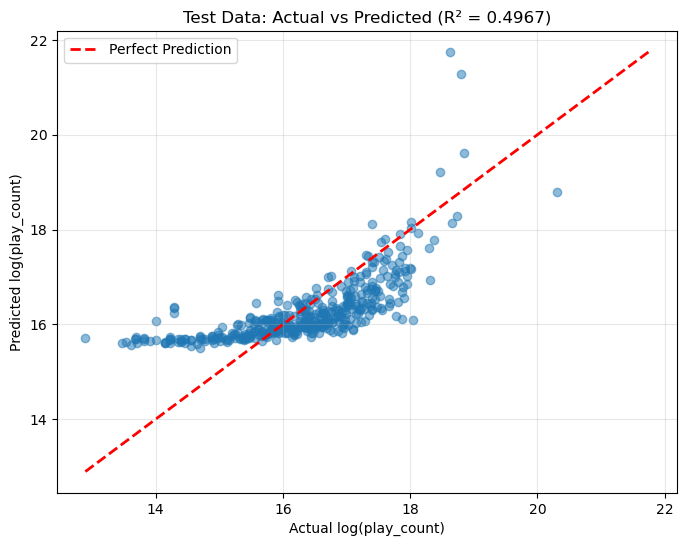

In [93]:
# Visualize model performance
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test_log, preds_log, alpha=0.5)
min_val = min(y_test_log.min(), preds_log.min())
max_val = max(y_test_log.max(), preds_log.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual log(play_count)')
plt.ylabel('Predicted log(play_count)')
plt.title(f'Test Data: Actual vs Predicted (R² = {r2_log:.4f})')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [ ]:
# summary
# we did: Linear Regression + log target + feature scaling + proper evaluation in log space
